## 1. Introduction

The goal of this project is to compare the performance of different approaches of hypterparameter selection running a convolutional neural network. The two competing methods are a sophisticated hyperparameter optimization approach using a Gaussian Process versus a simple Random Grid Search. Both methods were developed in order to minimize the running time of optimization process of expensive models. The Gaussian Process uses posterior distributions and certain acquisition functions to determine a new set of hyperparameters. On the other hand, a Random Grid Search simply draws from a set of pre-defined distributions, each for every hyperparameter. The two approaches are presented below in more detail and compared in terms of image-classification accuracy.  

## 2. Model, data and hyperparameters

We use a version of the Resnet-34 model (https://www.kaggle.com/pytorch/resnet34) from the fastai library (https://github.com/fastai/fastai) in a binary image classification setting. The dataset contains 25,000 photos of cats and dogs for training, and another 12,500 for testing. The convolutional layers of the model were pretrained on 1.2 million photos from ImageNet. For the sake of simplicity, we do not retrain the convolutional layers of the model, but only train the dense layers in the second part of the model. For training, we use stochastic gradient descent with restarts as implemented in the fastai library. Thus, we tune the following hyperparameters:
- max_zoom: the maximum zoom when augmenting the training data 
- lr: the maximum learning rate to start with 
- ps: dropout used by the model 
- epochs: number of cycles over the training data (misleading name, but we want to be consistent with fastai)
- cycle_len: length of first cycle in epochs (1 epoch = 1 iteration over the training data) 
- cycle_mult: multiplier for the length of consecutive cycles in terms of the previous one

#### Exemplary visualisation of SGDC with restarts for lr=0.1, epochs=3, cycle_len=2, cycle_mult=2

<img src="plot_lr.png" width="60%">

## 3. Hyperparameter optimisation

We use Bayesian Optimisation to find the set of hyperparameters that optimises the generalization performance of the Convolutional Neural Network. In particular, we choose the Gaussian Process (GP) as the surrogate model  with squared exponential kernel, and we try this for different types of acquisition functions (Expected Improvement, Probability Improvement, UCB and predictive entropy) . 

We assume that $f(\mathbf{x})$ is a black-box function that maps a set of hyperparameters $\mathbf{x}$ to the generalization performance of our Machine Learning model. We consider this function as a vector of infinite size, and we assume it follows a multivariate gaussian distribution. We write this as

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}'))$$

where $m(\mathbf{x}) = \mathbb{E}[f(\mathbf{x})]$ and $k(\mathbf{x},\mathbf{x}') = \mathbb{E}\big[\big(f(\mathbf{x}) - m(\mathbf{x})\big)\big(f(\mathbf{x}')-m(\mathbf{x}')\big)\big]$. Furthermore, we choose the squared exponential kernel

$$k(x, x') = \sigma^2 exp\big(-\frac{(x - x')^2}{2 \lambda^2} \big)$$

We can make predictions for new points $X_*$ given past data $\{\mathbf{X},\mathbf{y}\}$, where $y = f(\mathbf{x}) + noise$, using the mean and covariance of the gaussian posterior

$$\mathbf{f_*} \sim \mathcal{N} \big(\bar{\mathbf{f_*}}, cov(\mathbf{f_*}) \big)$$

where 

$$\bar{\mathbf{f_*}} = K(X_*, X)\big[K(X,X) + \sigma^2 \mathbf{I} \big]^{-1} \mathbf{y}$$

$$cov(\mathbf{f_*}) = K(X_*, X_*) - K(X_*, X)\big[ K(X, X) + \sigma^2 \mathbf{I}\big]^{-1}K(X, X_*)$$

### Acquisition functions

The acquisition function, which we denote by $a : \mathcal{X} → \mathbb{R}^+$, determines what point in $\mathcal{X}$ should be evaluated next via a proxy optimization $\mathbf{x}_{next} = \arg \max_\mathbf{x} a(\mathbf{x})$, where different functions have been proposed. These functions depend on the previous observations as well as the GP hyperparameters. Fortunately, under the Gaussian process prior, these functions depend on the model solely through its predictive mean function $\mu(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta)$ and predictive variance function $\sigma^2(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta)$. We denote $\mathbf{x}_{best} = \arg \max_{\mathbf{x}_n} f(\mathbf{x}_n)$

#### Probability of Improvement

Maximizing the probability of improving over the best current value:

$$a_{PI}(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta) = \Phi(\gamma(\mathbf{x})), \mbox{  where  } \gamma(\mathbf{x}) = \frac{f(\mathbf{x}_{best}) - \mu(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta)}{\sigma(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta)}$$



#### Expected Improvement

Maximize the expected improvement over the current best value: 

$$a_{EI}(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta) = \sigma(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta)\big(\gamma(\mathbf{x})\Phi\big(\gamma(\mathbf{x})\big) + \mathcal{N}\big(\gamma(\mathbf{x}); 0 , 1\big)\big)$$


#### Upper Confidence Bound (UCB)

Another alternative is to build acquisition functions that minimize regret over the course of their optimisation:

$$a_{UCB}(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta) = \mu(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta) + \kappa \sigma(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta)$$

where $\kappa$ can be tuned to balance exploration vs exploitation.

#### Entropy Search (as implemented by pyGPGO package)

An alternative approach is to maximize the expected posterior information gain about the global maximizer $\mathbf{x}_*$ evaluated over the grid in the input space. This information gain can be measured in terms of the negative differential entropy. In practice, the following formula is implemented for the entropy search:

$$a_{ES}(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta) = \frac{1}{2}\log\big(2 \pi e (\sigma(\mathbf{x}; \{\mathbf{x}_n, y_n\}, \theta) + noise) \big)$$


## 4. Implementation and results

### Setup 

In [1]:
import numpy as np
from pyGPGO.covfunc import squaredExponential
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO
import pandas as pd
from image_classifier import *
%matplotlib inline
%precision 3

'%.3f'

### Main function

In [2]:
def hyp_optim_gp(acq_fn, fn, param_sets, max_iter=20, init_evals=3):
    """
    fit GP hyperparameter optimisation procedure 
    with given parameters and returns time series of 
    optimal accuracy at each step
    """
    np.random.seed(314)
    sexp = squaredExponential(); gp = GaussianProcess(sexp)
    acq = Acquisition(mode=acq_fn) if acq_fn != "RS" else Acquisition("UCB")
    gpgo = GPGO(gp, acq, fn, param_sets)
    if acq_fn == "RS": # RS = random search
        init_history = []
        # intial runs
        for it in range(init_evals): 
            params = gpgo._sampleParam()
            init_history.append(fn(**params))
        history = [np.max(init_history)]
        for it in range(max_iter): 
            params = gpgo._sampleParam()
            print(np.max(fn(**params)))
            print(history[-1])
            history.append(np.max((fn(**params), history[-1])))
        return history
    else: 
        gpgo.run(max_iter=max_iter, init_evals=init_evals)
        return gpgo.history

### Define parameter sets

In [3]:
param_sets = {
    'max_zoom': ('cont', [1, 4]), 
    'lr': ('cont', [1e-10, 2]),
    'ps': ('cont', [.2, .8]),
    'epochs': ('int', [1, 5]),
    'cycle_len': ('int', [1, 2]),
    'cycle_mult': ('int', [1, 2])
}

### Run model and plot results

In [4]:
acq_fns = ['RS', 'ExpectedImprovement', 'ProbabilityImprovement', 'UCB', 'Entropy']
max_iter = 30; init_evals = 3
df_acc = pd.DataFrame(columns=acq_fns, dtype=float)
for acq_fn in acq_fns: 
    print("------------------------------------", acq_fn, "-----------------------------------")
    history = hyp_optim_gp(acq_fn, fit_eval_imageclassifier, param_sets, max_iter, init_evals)
    df_acc[acq_fn] = history
df_acc.index = list(range(init_evals, init_evals + max_iter + 1))

------------------------------------ RS -----------------------------------
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.


epoch      trn_loss   val_loss   accuracy                   
    0      65.228875  17.41553   0.9875    
    1      216.876787 47.826204  0.989                          
    2      4797.908625 1465.680239 0.989                        



epoch      trn_loss   val_loss   accuracy                       
    0      1.2461186084830993e+22 1.4842120972102405e+20 0.5       
    1      nan        nan        0.5                            
    2      nan        nan        0.5                       
    3      nan        nan        0.5                       



epoch      trn_loss   val_loss   accuracy                       
    0      79922.677256 19526.1285 0.9835    



epoch      trn_loss   val_loss   accuracy                       
    0      170738573775.76825 49666948268.032 0.987     

0.987                                        
0.989


epoch      trn_loss   val_loss   accuracy                       
    0      170738573775.76825 49666948268.032 0.987     



epoch      trn_loss   val_loss   accuracy                     
    0      0.048146   0.026622   0.988     
    1      0.037853   0.024808   0.99                         
    2      0.031321   0.024904   0.9895                       
    3      0.034301   0.024369   0.9905                       

0.9905                                       
0.989


epoch      trn_loss   val_loss   accuracy                     
    0      0.04681    0.025344   0.9895    
    1      0.036086   0.025382   0.9895                       
    2      0.032283   0.022392   0.99                         
    3      0.033757   0.022529   0.9905                       



epoch      trn_loss   val_loss   accuracy                       
    0      5.167438479474063e+20 7.26228475121899e+18 0.5       

0.5                                          
0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      5.167438479474063e+20 7.26228475121899e+18 0.5       



epoch      trn_loss   val_loss   accuracy                    
    0      0.383502   0.111861   0.988     
    1      0.301813   0.100965   0.9915                      

0.9915                                       
0.9905


epoch      trn_loss   val_loss   accuracy                    
    0      0.383502   0.111861   0.988     
    1      0.257217   0.052929   0.993                       



epoch      trn_loss   val_loss   accuracy                       
    0      4.525516960936084e+18 1.7840625864416637e+17 0.5       
    1      nan        nan        0.5                            

0.5                                          
0.993


epoch      trn_loss   val_loss   accuracy                       
    0      7.296183586371756e+18 1.582324187479765e+17 0.5       
    1      1.7688739143038853e+31 6.247890065144254e+28 0.5       



epoch      trn_loss   val_loss   accuracy                    
    0      0.110855   0.035046   0.99      
    1      0.070686   0.024755   0.991                        
    2      0.047544   0.023637   0.99                         
    3      0.042768   0.027074   0.9885                       

0.9885                                       
0.993


epoch      trn_loss   val_loss   accuracy                    
    0      0.110855   0.035046   0.99      
    1      0.070686   0.024755   0.991                        
    2      0.047544   0.023637   0.99                         
    3      0.042778   0.027185   0.9885                       



epoch      trn_loss   val_loss   accuracy                   
    0      185.369511 47.783261  0.989     
    1      127230.364747 32835.012258 0.9885                    
    2      69203652.423882 16459811.1 0.9905                    

0.9905                                       
0.993


epoch      trn_loss   val_loss   accuracy                   
    0      185.369511 47.783261  0.989     
    1      127230.364747 32772.87098 0.989                      
    2      73857573.983161 19820156.028 0.989                   



epoch      trn_loss   val_loss   accuracy                     
    0      0.075187   0.030416   0.99      
    1      0.046006   0.025269   0.991                        
    2      0.037768   0.024011   0.99                         

0.99                                         
0.993


epoch      trn_loss   val_loss   accuracy                     
    0      0.080617   0.029914   0.991     
    1      0.047797   0.025209   0.991                        
    2      0.037684   0.023159   0.99                         



epoch      trn_loss   val_loss   accuracy                    
    0      0.105608   0.04025    0.991     
    1      0.049431   0.027126   0.9905                       

0.9905                                       
0.993


epoch      trn_loss   val_loss   accuracy                    
    0      0.105608   0.04025    0.991     
    1      0.049431   0.027126   0.9905                       



epoch      trn_loss   val_loss   accuracy                    
    0      0.202442   0.048734   0.9905    
    1      0.060932   0.024475   0.9905                       

0.9905                                       
0.993


epoch      trn_loss   val_loss   accuracy                    
    0      0.202442   0.048734   0.9905    
    1      0.061339   0.024635   0.9905                       



epoch      trn_loss   val_loss   accuracy                       
    0      4375.586802 975.138764 0.9885    
    1      107749.679882 27299.722991 0.9895                    

0.9895                                       
0.993


epoch      trn_loss   val_loss   accuracy                       
    0      1987.196475 413.4652   0.99      
    1      39827135.830797 6561775.462 0.987                    



epoch      trn_loss   val_loss   accuracy                    
    0      0.109756   0.040695   0.9895    
    1      0.059751   0.024251   0.9915                       
    2      0.042957   0.023446   0.9915                       
    3      0.040316   0.02735    0.989                        

0.989                                        
0.993


epoch      trn_loss   val_loss   accuracy                    
    0      0.119079   0.040171   0.99      
    1      0.061576   0.025305   0.99                         
    2      0.042853   0.022773   0.991                        
    3      0.041868   0.026957   0.989                        



epoch      trn_loss   val_loss   accuracy                     
    0      0.06684    0.026583   0.989     
    1      0.041258   0.026178   0.99                         

0.99                                         
0.993


epoch      trn_loss   val_loss   accuracy                     
    0      0.067651   0.026524   0.9885    
    1      0.040302   0.026429   0.99                         



epoch      trn_loss   val_loss   accuracy                   
    0      4.295219   1.051263   0.9895    

0.9895                                       
0.993


epoch      trn_loss   val_loss   accuracy                   
    0      4.295219   1.051263   0.9895    



epoch      trn_loss   val_loss   accuracy                       
    0      164351.981889 36354.503719 0.9895    
    1      21009902769.865105 3597711384.576 0.99               

0.99                                         
0.993


epoch      trn_loss   val_loss   accuracy                       
    0      107462.386842 24632.113438 0.988     
    1      28465460880.46625 6540854883.328 0.988               



epoch      trn_loss   val_loss   accuracy                    
    0      0.229543   0.043596   0.9905    
    1      0.099207   0.028596   0.988                        

0.988                                        
0.993


epoch      trn_loss   val_loss   accuracy                    
    0      0.229543   0.043596   0.9905    
    1      0.099098   0.028553   0.988                        



epoch      trn_loss   val_loss   accuracy                    
    0      0.116494   0.039352   0.9905    

0.9905                                       
0.993


epoch      trn_loss   val_loss   accuracy                    
    0      0.116252   0.038841   0.9905    



epoch      trn_loss   val_loss   accuracy                       
    0      173297474042962.75 42664369925914.625 0.986     

0.986                                        
0.993


epoch      trn_loss   val_loss   accuracy                       
    0      175878756540740.1 33826854745931.777 0.986     



epoch      trn_loss   val_loss   accuracy                     
    0      0.056119   0.031602   0.9885    
    1      0.049346   0.026508   0.9895                       

0.9895                                       
0.993


epoch      trn_loss   val_loss   accuracy                     
    0      0.056119   0.031602   0.9885    
    1      0.04952    0.026483   0.9895                       



epoch      trn_loss   val_loss   accuracy                       
    0      6414035.566059 1752443.376 0.989     
    1      1541874701995.4163 308727601168.384 0.989            
    2      6.699724270634102e+19 4610938900276314.0 0.5         

0.5                                          
0.993


epoch      trn_loss   val_loss   accuracy                       
    0      6414035.566059 1752443.376 0.989     
    1      1541874701995.4163 308727601168.384 0.989            
    2      6.699724270634102e+19 4610938900276314.0 0.5         



epoch      trn_loss   val_loss   accuracy                   
    0      1.647256   0.579806   0.986     
    1      3.679138   0.766041   0.991                      
    2      1.776746   0.614698   0.988                      

0.988                                        
0.993


epoch      trn_loss   val_loss   accuracy                   
    0      1.647256   0.579806   0.986     
    1      2.177092   0.461805   0.9915                     
    2      4.607329   1.823683   0.989                      



epoch      trn_loss   val_loss   accuracy                    
    0      0.182135   0.041439   0.9885    
    1      0.077285   0.028471   0.9885                       

0.9885                                       
0.993


epoch      trn_loss   val_loss   accuracy                    
    0      0.21465    0.038773   0.9885    
    1      0.077633   0.027105   0.9905                       



epoch      trn_loss   val_loss   accuracy                       
    0      1169605011.504837 407953843.2 0.988     
    1      478141920468870.75 55429305424936.96 0.9905          
    2      1.2147804110419392e+23 5.504613168433764e+18 0.5       

0.5                                          
0.993


epoch      trn_loss   val_loss   accuracy                       
    0      1148461042.541196 401120362.24 0.9885    
    1      82505019693.74026 12088278630.4 0.986                
    2      2.664371024124058e+21 2.5930882229469184e+16 0.5       



epoch      trn_loss   val_loss   accuracy                   
    0      3.237601   0.292878   0.981     
    1      29.986719  3.818237   0.9835                     
    2      103.536826 16.861233  0.985                          

0.985                                        
0.993


epoch      trn_loss   val_loss   accuracy                   
    0      3.171258   0.349893   0.9805    
    1      8.11392    1.149097   0.982                      
    2      25.037919  3.56048    0.985                      



epoch      trn_loss   val_loss   accuracy                       
    0      9590280644079.406 2049958622527.488 0.9875    
    1      4.841848357382263e+23 1.3773037723805748e+21 0.5       

0.5                                          
0.993


epoch      trn_loss   val_loss   accuracy                       
    0      2781609551552.03 587731689144.32 0.9875    
    1      4.7593608419977514e+23 9.767741939653408e+19 0.5       



epoch      trn_loss   val_loss   accuracy                       
    0      34995.691127 8199.057891 0.988     
    1      973886170.980077 179339533.696 0.989                 
    2      42439288441309.16 7297771577016.32 0.9875            
    3      2.615429112109053e+18 1.3910654066716836e+16 0.5       

0.5                                          
0.993


epoch      trn_loss   val_loss   accuracy                       
    0      34995.691127 8199.057891 0.988     
    1      1053024316.751867 219354041.536 0.989                
    2      117185145579054.31 29560534256844.8 0.986            
    3      6.466602568100644e+18 780824848254369.8 0.5          



epoch      trn_loss   val_loss   accuracy                     
    0      0.067482   0.025463   0.9905    

0.9905                                       
0.993


epoch      trn_loss   val_loss   accuracy                     
    0      0.067613   0.025452   0.9905    



epoch      trn_loss   val_loss   accuracy                     
    0      0.055173   0.025166   0.9905    
    1      0.039244   0.025324   0.991                        
    2      0.034795   0.022821   0.9905                       
    3      0.036203   0.02408    0.9895                       

0.9895                                       
0.993


epoch      trn_loss   val_loss   accuracy                     
    0      0.055538   0.025427   0.9905    
    1      0.039338   0.024853   0.992                        
    2      0.035493   0.022603   0.99                         
    3      0.036035   0.023918   0.99                         



epoch      trn_loss   val_loss   accuracy                     
    0      0.058704   0.032754   0.986     

0.986                                        
0.993


epoch      trn_loss   val_loss   accuracy                     
    0      0.058705   0.032759   0.986     



epoch      trn_loss   val_loss   accuracy                    
    0      0.575254   0.103195   0.9865    
    1      0.381636   0.088541   0.99                        
    2      2.836325   0.316582   0.989                      
    3      20.291825  5.343419   0.9885                     

0.9885                                       
0.993


epoch      trn_loss   val_loss   accuracy                    
    0      0.575254   0.103195   0.9865    
    1      0.35385    0.080745   0.9915                      
    2      2.248017   1.03112    0.9905                     
    3      3.957794   0.951153   0.987                      

------------------------------------ ExpectedImprovement -----------------------------------
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.


epoch      trn_loss   val_loss   accuracy                   
    0      66.371224  16.225595  0.987     
    1      1484.2753  370.272178 0.9905                         
    2      21166.881311 3602.619531 0.99                        



epoch      trn_loss   val_loss   accuracy                       
    0      1.1117259720807173e+22 3.94646393365811e+19 0.5       
    1      nan        nan        0.5                            
    2      nan        nan        0.5                       
    3      nan        nan        0.5                       



epoch      trn_loss   val_loss   accuracy                       
    0      79922.677256 19526.1285 0.9835    

init   	 [3.751 1.177 0.359 3.    1.    1.   ]. 	    0.99 	   0.99
init   	 [2.798 1.832 0.773 4.    1.    1.   ]. 	     0.5 	   0.99
init   	 [1.781 1.824 0.356 1.    1.    1.   ]. 	  0.9835 	   0.99


epoch      trn_loss   val_loss   accuracy                       
    0      559.318132 145.841535 0.987     
    1      8026922.968505 1805634.992 0.991                     

1      	 [2.744 1.531 0.386 2.112 1.    1.   ]. 	  0.991 	 0.991 


epoch      trn_loss   val_loss   accuracy                     
    0      0.052223   0.027161   0.989     
    1      0.040727   0.024805   0.9905                       

2      	 [2.891 0.939 0.2   2.954 1.    1.   ]. 	  0.9905 	 0.991 


epoch      trn_loss   val_loss   accuracy                       
    0      1.4904499750205433e+22 1.3495735458250642e+22 0.5       
    1      3.819591032205786e+19 1.773104732612969e+17 0.5       
    2      inf        nan        0.503                          
    3      nan        nan        0.5                       
    4      nan        nan        0.5                       

3      	 [3.161 1.221 0.799 2.778 1.473 1.   ]. 	  0.5    	 0.991 


epoch      trn_loss   val_loss   accuracy                   
    0      1.509736   0.37661    0.988     

4      	 [1.862 1.266 0.2   1.765 1.    1.   ]. 	  0.988  	 0.991 


epoch      trn_loss   val_loss   accuracy                   
    0      3.455528   1.658864   0.9865    
    1      2.047299   0.405461   0.991                      

5      	 [2.511 1.25  0.2   1.156 1.    1.   ]. 	  0.991 	 0.991 


epoch      trn_loss   val_loss   accuracy                       
    0      53284.089294 11763.398266 0.9855    
    1      5.313186255125096e+21 5.856906473539785e+21 0.5       

6      	 [2.235 1.684 0.2   1.488 1.    1.625]. 	  0.5    	 0.991 


epoch      trn_loss   val_loss   accuracy                     
    0      0.048921   0.024987   0.9885    
    1      0.036472   0.024856   0.991                        

7      	 [3.373 0.803 0.2   2.153 1.    1.   ]. 	  0.991 	 0.991 


epoch      trn_loss   val_loss   accuracy                       
    0      3652978707156476.0 618644035325657.1 0.9865    

8      	 [1.968 1.187 0.8   1.213 1.    1.   ]. 	  0.9865 	 0.991 


epoch      trn_loss   val_loss   accuracy                   
    0      7.129279   1.513733   0.988     
    1      12399623.891497 2022525.758 0.9905                   

9      	 [3.344 1.476 0.2   2.682 1.    1.   ]. 	  0.9905 	 0.991 


epoch      trn_loss   val_loss   accuracy                     
    0      0.05181    0.024816   0.9905    

10     	 [2.507 0.732 0.254 1.936 1.    1.   ]. 	  0.9905 	 0.991 


epoch      trn_loss   val_loss   accuracy                     
    0      0.072548   0.026146   0.988     

11     	 [1.39  1.005 0.2   1.    1.    1.   ]. 	  0.988  	 0.991 


epoch      trn_loss   val_loss   accuracy                     
    0      0.048794   0.024834   0.989     
    1      0.037066   0.023476   0.9925                       
    2      0.034106   0.021254   0.9915                       
    3      0.034308   0.021885   0.989                        

12     	 [3.648 0.834 0.2   4.043 1.    1.   ]. 	  0.989  	 0.991 


epoch      trn_loss   val_loss   accuracy                     
    0      0.059519   0.03005    0.9905    
    1      0.039873   0.026382   0.9885                       
    2      0.028827   0.027817   0.9885                       

13     	 [3.794 0.194 0.2   3.369 1.    1.   ]. 	  0.9885 	 0.991 


epoch      trn_loss   val_loss   accuracy                     
    0      0.043633   0.025206   0.991     
    1      0.034805   0.024931   0.9925                       
    2      0.03274    0.024829   0.99                         

14     	 [3.558 0.792 0.2   3.324 1.    1.   ]. 	  0.99   	 0.991 


epoch      trn_loss   val_loss   accuracy                   
    0      2.470114   0.482876   0.988     
    1      1.778074   0.356247   0.989                      
    2      2.153329   0.482477   0.989                      
    3      1.563857   0.307899   0.99                       

15     	 [4.    0.287 0.8   4.112 1.    1.   ]. 	  0.99   	 0.991 


epoch      trn_loss   val_loss   accuracy                    
    0      1.002502   0.870221   0.407     
    1      1.001571   0.873376   0.4045                      
    2      1.00533    0.883125   0.402                       
    3      1.010643   0.864092   0.4135                      

16     	 [3.22  0.    0.373 4.325 1.    1.   ]. 	  0.4135 	 0.991 


epoch      trn_loss   val_loss   accuracy                       
    0      910251515655532.1 176339383878680.56 0.986     
    1      2.5294795514420833e+26 2.9761569215478962e+23 0.5       
    2      1.2300606986693514e+34 1.8057137487663823e+31 0.5       
    3      nan        nan        0.5                           

17     	 [4.    1.29  0.775 4.348 1.    1.   ]. 	  0.5    	 0.991 


epoch      trn_loss   val_loss   accuracy                     
    0      0.043365   0.024653   0.99      
    1      0.030221   0.024932   0.9905                       
    2      0.030054   0.022226   0.9915                       

18     	 [4.    0.422 0.2   3.93  1.    1.   ]. 	  0.9915 	 0.9915


epoch      trn_loss   val_loss   accuracy                    
    0      0.190466   0.040268   0.99      
    1      0.09347    0.028091   0.99                         
    2      0.081001   0.026375   0.9895                       

19     	 [4.    0.092 0.8   3.101 1.    1.   ]. 	  0.9895 	 0.9915


epoch      trn_loss   val_loss   accuracy                       
    0      2484021.929481 639258.955 0.9885    

20     	 [4.    1.643 0.533 1.857 1.    1.   ]. 	  0.9885 	 0.9915


epoch      trn_loss   val_loss   accuracy                       
    0      3.054675374811732e+21 1.1476390003870482e+19 0.5       

21     	 [1.    1.588 0.8   1.    1.    1.   ]. 	  0.5    	 0.9915


epoch      trn_loss   val_loss   accuracy                   
    0      6.981659   1.319767   0.99      

22     	 [1.892 1.234 0.261 1.    1.    1.   ]. 	  0.99   	 0.9915


epoch      trn_loss   val_loss   accuracy                       
    0      2.3163327889162776e+27 7.82470300769797e+24 0.5       

23     	 [2.921 2.    0.8   1.    1.    1.   ]. 	  0.5    	 0.9915


epoch      trn_loss   val_loss   accuracy                     
    0      0.068046   0.032138   0.99      

24     	 [1.114 0.025 0.427 1.402 1.    1.   ]. 	  0.99   	 0.9915


epoch      trn_loss   val_loss   accuracy                   
    0      268.444738 51.897114  0.9885    
    1      35891.698417 6428.109533 0.9885                      

25     	 [1.529 0.45  0.8   2.292 1.    1.   ]. 	  0.9885 	 0.9915


epoch      trn_loss   val_loss   accuracy                     
    0      0.042576   0.02392    0.991     

26     	 [1.    0.478 0.2   1.905 1.    1.   ]. 	  0.991  	 0.9915


epoch      trn_loss   val_loss   accuracy                    
    0      0.718373   0.140373   0.99      

27     	 [1.476 0.552 0.593 1.582 1.    1.   ]. 	  0.99   	 0.9915


epoch      trn_loss   val_loss   accuracy                     
    0      0.04745    0.024481   0.991     
    1      0.039386   0.024334   0.991                        
    2      0.035355   0.024708   0.992                        

28     	 [1.652 0.854 0.2   3.184 1.    1.   ]. 	  0.992 	 0.992 


epoch      trn_loss   val_loss   accuracy                    
    0      0.967278   0.905673   0.407     
    1      0.970159   0.90846    0.405                       

29     	 [1.725 0.    0.2   2.732 1.    1.   ]. 	  0.405  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      38255834151912.086 9024542768889.855 0.9855    
    1      7.867556901121044e+24 8.768250544332496e+21 0.5       

30     	 [1.759 1.2   0.773 2.857 1.    1.   ]. 	  0.5    	 0.992 
------------------------------------ ProbabilityImprovement -----------------------------------
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.


epoch      trn_loss   val_loss   accuracy                   
    0      65.228875  17.41553   0.9875    
    1      216.876787 47.826204  0.989                          
    2      4797.908625 1465.680239 0.989                        



epoch      trn_loss   val_loss   accuracy                       
    0      1.1117259720807173e+22 3.94646393365811e+19 0.5       
    1      nan        nan        0.5                            
    2      nan        nan        0.5                       
    3      nan        nan        0.5                       



epoch      trn_loss   val_loss   accuracy                       
    0      244837.622091 64328.597688 0.984     

init   	 [3.751 1.177 0.359 3.    1.    1.   ]. 	   0.989 	  0.989
init   	 [2.798 1.832 0.773 4.    1.    1.   ]. 	     0.5 	  0.989
init   	 [1.781 1.824 0.356 1.    1.    1.   ]. 	   0.984 	  0.989


epoch      trn_loss   val_loss   accuracy                    
    0      0.905741   0.218307   0.9895    
    1      6.083515   1.114495   0.991                      
    2      16.582353  3.144907   0.992                      

1      	 [3.743 1.182 0.362 3.004 1.    1.   ]. 	  0.992 	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      8.483751   3.44739    0.988     
    1      72.891125  19.91794   0.988                      
    2      1029.328783 309.936873 0.991                         

2      	 [3.703 1.205 0.374 3.024 1.    1.   ]. 	  0.991  	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      2.414715   0.61632    0.987     
    1      19.801998  59.151015  0.964                      
    2      235.030409 50.995203  0.99                           
    3      5773.623367 5360.977391 0.988                        

3      	 [3.731 1.196 0.374 3.051 1.    1.   ]. 	  0.988  	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      13.465838  4.018858   0.9875    
    1      105.983909 21.187451  0.9895                    

4      	 [3.7   1.199 0.365 2.979 1.    1.   ]. 	  0.9895 	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      506407.515886 117039.053562 0.9885    

5      	 [1.671 1.865 0.362 1.    1.    1.   ]. 	  0.9885 	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      36.20688   13.363023  0.986     
    1      74.048728  16.784236  0.99                       
    2      7469.511732 1993.72635 0.988                         

6      	 [3.692 1.16  0.354 3.016 1.    1.   ]. 	  0.988  	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      13.011939  1.883606   0.9895    
    1      43.366358  10.470419  0.991                      
    2      19860.28443 4500.397285 0.99                         

7      	 [3.733 1.238 0.361 3.001 1.    1.   ]. 	  0.99   	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      18.975967  4.470287   0.9885    
    1      1577.740047 390.89516  0.99                          

8      	 [3.727 1.203 0.411 2.996 1.    1.   ]. 	  0.99   	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      59233137.841264 10703958.016 0.991     

9      	 [1.714 1.899 0.425 1.    1.    1.   ]. 	  0.991  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      47893714.920001 13016136.27375 0.9855    

10     	 [1.722 1.925 0.389 1.    1.    1.   ]. 	  0.9855 	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      12732862.798429 2232339.4205 0.991     

11     	 [1.699 1.861 0.445 1.    1.    1.   ]. 	  0.991  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      101496696.076447 23578161.868 0.989     

12     	 [1.703 1.875 0.441 1.    1.    1.032]. 	  0.989  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      84500889.083915 30535370.328 0.985     

13     	 [1.703 1.875 0.441 1.    1.032 1.   ]. 	  0.985  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      14198635.240689 3028189.4355 0.988     

14     	 [1.701 1.876 0.441 1.032 1.    1.   ]. 	  0.988  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      27967250.639984 7872077.966 0.9865    

15     	 [1.686 1.897 0.463 1.    1.    1.   ]. 	  0.9865 	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      818440.633572 276752.2575 0.9885    

16     	 [1.728 1.851 0.422 1.    1.    1.   ]. 	  0.9885 	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      2597171.150221 762370.656625 0.9855    

17     	 [1.674 1.846 0.408 1.    1.    1.   ]. 	  0.9855 	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      597241709753.0907 190290181750.784 0.986     

18     	 [1.784 1.88  0.561 1.    1.    1.   ]. 	  0.986  	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      13.129977  3.499966   0.99      
    1      115.444473 18.677964  0.991                     
    2      284.263226 665.485905 0.9825                     
    3      566039.996658 95628.576986 0.989                     

19     	 [3.721 1.208 0.373 3.004 1.    1.046]. 	  0.989  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      13216.878016 2406.606612 0.9885    

20     	 [1.707 1.861 0.2   1.    1.    1.   ]. 	  0.9885 	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      69.808482  10.731488  0.986     

21     	 [1.7   1.861 0.2   1.    1.    1.087]. 	  0.986  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      10516.303049 1334.795132 0.9895    
    1      21246014.010401 5353062.404 0.9865                   

22     	 [1.697 1.861 0.2   1.086 1.    1.016]. 	  0.9865 	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      83.843171  19.032962  0.989     
    1      4626.466855 754.938862 0.9895                        
    2      816243.540797 181984.092625 0.9905                   

23     	 [3.62  1.286 0.417 3.032 1.    1.   ]. 	  0.9905 	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      30.194528  7.073558   0.9895    
    1      92.883678  11.109295  0.9895                     
    2      4696.833524 1189.414574 0.99                         

24     	 [3.579 1.318 0.364 3.052 1.    1.   ]. 	  0.99   	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      36.77976   7.10398    0.989     
    1      4457.199669 887.440763 0.9905                        
    2      678533.043956 136307.907625 0.9885                   

25     	 [3.482 1.312 0.407 3.069 1.    1.   ]. 	  0.9885 	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      1333.434311 377.617632 0.9875    
    1      2820780.985544 699490.7715 0.985                     
    2      38562785.298973 133478126.88 0.9615                  
    3      4.925709453796572e+16 1.128285233753568e+16 0.988     

26     	 [3.406 1.403 0.414 3.092 1.    1.105]. 	  0.988  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      8889.603993 3506.004637 0.9845    
    1      1191390549.980425 243824885.248 0.987                
    2      128274422083.67476 324854437904.384 0.9805           
    3      9.886091808472731e+20 2.92930980115282e+18 0.5       

27     	 [3.158 1.569 0.439 3.106 1.    1.091]. 	  0.5    	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      189.179707 30.150124  0.9905    
    1      388202.228309 68790.421406 0.9895                    
    2      2823660.326791 5118100.336 0.9785                    
    3      519376487075265.25 707244488191377.4 0.982           

28     	 [3.474 1.354 0.403 3.158 1.    1.154]. 	  0.982  	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      57.873489  18.789627  0.9885    
    1      67751.157332 10031.782088 0.9885                     
    2      339474.790596 175476.342375 0.9875                   
    3      1034134535.37429 259396081.072 0.985                 

29     	 [3.52  1.3   0.374 3.021 1.    1.123]. 	  0.985  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      222.158115 51.727509  0.9875    
    1      386408.258607 1459118.452992 0.9685                  
    2      5081761777.736531 1174912629.76 0.9885               
    3      1329089033732.0767 2676405713240.064 0.9645          

30     	 [3.519 1.377 0.435 3.095 1.003 1.079]. 	  0.9645 	 0.992 
------------------------------------ UCB -----------------------------------
Evaluation 	 Proposed point 	  Current eval. 	 Best eval.


epoch      trn_loss   val_loss   accuracy                   
    0      65.228875  17.41553   0.9875    
    1      329.001786 78.114606  0.988                          
    2      1185.527141 365.843599 0.9895                        



epoch      trn_loss   val_loss   accuracy                       
    0      1.1117259720807173e+22 3.94646393365811e+19 0.5       
    1      nan        nan        0.5                            
    2      nan        nan        0.5                       
    3      nan        nan        0.5                       



epoch      trn_loss   val_loss   accuracy                       
    0      79922.677256 19526.1285 0.9835    

init   	 [3.751 1.177 0.359 3.    1.    1.   ]. 	  0.9895 	 0.9895
init   	 [2.798 1.832 0.773 4.    1.    1.   ]. 	     0.5 	 0.9895
init   	 [1.781 1.824 0.356 1.    1.    1.   ]. 	  0.9835 	 0.9895


epoch      trn_loss   val_loss   accuracy                       
    0      6868.097478 1231.083564 0.9895    
    1      2001203212.697382 447288592.896 0.9895               

1      	 [2.704 1.549 0.392 2.102 1.    1.   ]. 	  0.9895 	 0.9895


epoch      trn_loss   val_loss   accuracy                     
    0      0.042627   0.026022   0.99      
    1      0.049615   0.031276   0.9905                       

2      	 [2.743 0.65  0.2   2.995 1.    1.   ]. 	  0.9905 	 0.9905


epoch      trn_loss   val_loss   accuracy                    
    0      2.546781   4.384187   0.96      
    1      0.400834   0.247547   0.987                       
    2      0.289384   0.190569   0.987                       
    3      122.88481  238.972684 0.9555                      
    4      1550.057503 373.106825 0.9825                        
    5      71.116887  37.937221  0.992                         

3      	 [3.053 1.262 0.2   2.888 1.912 1.011]. 	  0.992 	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      7412940236982.076 1337296058580.992 0.987     
    1      9701537331639.754 4136079154216.96 0.991             
    2      8.354187785007866e+29 nan        0.617               
    3      nan        nan        0.5                       
    4      nan        nan        0.5                       
    5      nan        nan        0.5                       
    6      nan        nan        0.5                       

4      	 [3.07  1.061 0.76  2.805 1.304 1.792]. 	  0.5    	 0.992 


epoch      trn_loss   val_loss   accuracy                    
    0      0.367011   0.331575   0.9615    
    1      0.04376    0.027375   0.99                         
    2      0.108217   0.082964   0.9895                       

5      	 [1.792 1.122 0.2   1.862 1.618 1.   ]. 	  0.9895 	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.045962   0.024463   0.989     
    1      0.029471   0.02366    0.9895                       

6      	 [3.131 0.609 0.2   1.915 1.5   1.   ]. 	  0.9895 	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      1032476.411843 379386.888 0.988     
    1      14943.131847 4561.099795 0.9875                      

7      	 [2.548 1.637 0.2   1.161 1.907 1.   ]. 	  0.9875 	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.049736   0.029297   0.988     

8      	 [2.29  0.836 0.2   1.    1.028 1.   ]. 	  0.988  	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      4.272907360518219e+21 4.945016071751535e+21 0.5       

9      	 [1.934 1.126 0.8   1.    1.72  1.   ]. 	  0.5    	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.044137   0.022254   0.99      
    1      0.028635   0.022993   0.991                        
    2      0.03646    0.029117   0.9915                       
    3      0.036518   0.028984   0.9875                       
    4      0.022589   0.027729   0.989                        

10     	 [3.703 0.309 0.2   3.42  1.647 1.   ]. 	  0.989  	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      54.892334  18.825596  0.987     

11     	 [3.14  1.747 0.2   1.    1.    1.   ]. 	  0.987  	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.046429   0.023705   0.991     
    1      0.038028   0.022887   0.9905                       
    2      0.033162   0.023848   0.991                        
    3      0.033184   0.024362   0.9895                       

12     	 [3.557 0.806 0.2   4.172 1.    1.   ]. 	  0.9895 	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      11.775853  2.543108   0.991     
    1      0.276165   0.136099   0.9905                      
    2      1.351216   0.973635   0.99                        
    3      138317.098678 84133.170047 0.9845                    
    4      15019.098848 3120.161627 0.9875                      
    5      1305.908348 4732.363695 0.9895                       
    6      5551.826428 47943.505875 0.818                       

13     	 [4.    1.388 0.2   3.925 1.855 1.   ]. 	  0.818  	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.060655   0.024977   0.991     
    1      0.031179   0.022802   0.9905                       
    2      0.036223   0.032652   0.99                         
    3      0.052106   0.027876   0.991                        
    4      0.040451   0.022512   0.9905                       
    5      0.023862   0.022691   0.991                        
    6      0.031835   0.044605   0.9845                       

14     	 [2.784 0.681 0.2   4.112 1.902 1.   ]. 	  0.9845 	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      261816681693.4171 58126608318.464 0.9905    
    1      65821045962.59374 14484480192.512 0.9875             
    2      7.64666974777492e+20 8.506430978756345e+21 0.5       
    3      1.3701897021093616e+29 1.646831785377069e+29 0.5       
    4      2.4864395958893872e+26 1.1478780467179327e+25 0.5       

15     	 [3.336 0.762 0.8   3.722 1.561 1.   ]. 	  0.5    	 0.992 


epoch      trn_loss   val_loss   accuracy                   
    0      46.977363  7.378493   0.9885    
    1      24.326101  12.607739  0.99                       

16     	 [2.384 1.497 0.2   1.319 1.176 1.868]. 	  0.99   	 0.992 


epoch      trn_loss   val_loss   accuracy                       
    0      23452.720211 7108.47518 0.986     
    1      273.320485 133.122762 0.989                          
    2      12101.023195 6614.754155 0.992                       
    3      1007926603044766.1 5037326433257521.0 0.981          

17     	 [3.853 1.651 0.2   1.867 1.714 1.381]. 	  0.981  	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.052207   0.028308   0.99      
    1      0.028068   0.025203   0.99                         
    2      0.030532   0.027444   0.9895                       
    3      0.023012   0.030966   0.9865                       
    4      0.025638   0.027288   0.99                         
    5      0.017508   0.024667   0.991                        

18     	 [2.171 0.041 0.2   3.076 2.    1.   ]. 	  0.991  	 0.992 


epoch      trn_loss   val_loss   accuracy                    
    0      0.102605   0.040159   0.985     
    1      0.035625   0.025753   0.9895                       
    2      0.065407   0.089313   0.988                        
    3      0.121032   0.052978   0.983                        
    4      0.037966   0.029191   0.9865                       

19     	 [1.597 0.98  0.2   3.498 1.703 1.   ]. 	  0.986  	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.062559   0.040777   0.9875    
    1      0.039858   0.038841   0.988                        
    2      0.030849   0.032263   0.9895                       
    3      0.025792   0.032848   0.9875                       

20     	 [1.975 0.036 0.2   4.103 1.191 1.   ]. 	  0.9875 	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.04204    0.019898   0.991     
    1      0.027768   0.021204   0.9905                       
    2      0.038469   0.031355   0.9915                       
    3      0.038593   0.030335   0.984                        
    4      0.025622   0.028043   0.987                        
    5      0.019727   0.035771   0.987                        
    6      0.032181   0.024638   0.992                        
    7      0.018537   0.029429   0.992                        
    8      0.012126   0.033371   0.99                          
    9      0.02405    0.041403   0.9875                       
    10     0.018435   0.028827   0.99                         
    11     0.009384   0.030492   0.9905                        
    12     0.033854   0.039397   0.99                          
    13     0.01951    0.039169   0.9885                       
    14     0.008617   0.036286   0.9905                        
    15 

epoch      trn_loss   val_loss   accuracy                     
    0      0.052657   0.036324   0.988     
    1      0.040098   0.035033   0.9885                       
    2      0.029456   0.025971   0.99                         
    3      0.026271   0.029669   0.987                        
    4      0.031153   0.027581   0.9885                       

22     	 [1.372 0.181 0.2   2.884 1.099 1.437]. 	  0.9885 	 0.992 


epoch      trn_loss   val_loss   accuracy                    
    0      0.967288   0.905673   0.407     
    1      0.970159   0.90846    0.405                       
    2      0.971312   0.917766   0.4025                      
    3      0.986646   0.900704   0.417                       
    4      0.969191   0.897326   0.41                        
    5      0.963704   0.921334   0.4                         
    6      0.975014   0.908658   0.41                        
    7      0.961216   0.902947   0.4075                      
    8      0.970481   0.899338   0.4125                      
    9      0.974418   0.898525   0.411                       
    10     0.968985   0.909225   0.4055                      
    11     0.983924   0.907024   0.4085                      

23     	 [1.076 0.    0.2   3.771 1.992 1.346]. 	  0.4085 	 0.992 


epoch      trn_loss   val_loss   accuracy                    
    0      0.401639   0.062959   0.989     
    1      1.761706   0.675557   0.991                       
    2      0.054353   0.030671   0.99                         
    3      0.144887   0.055904   0.991                        
    4      778696.357287 1309982.101906 0.9745                  

24     	 [1.515 1.373 0.2   2.701 1.    1.801]. 	  0.9745 	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.044925   0.023473   0.99      
    1      0.030168   0.02418    0.99                         
    2      0.043079   0.02928    0.99                         
    3      0.053949   0.03046    0.9885                       
    4      0.032803   0.023614   0.9895                       
    5      0.021124   0.022242   0.9915                       
    6      0.028334   0.05009    0.985                        
    7      0.040067   0.026412   0.99                         
    8      0.020261   0.025543   0.99                         

25     	 [1.89  0.652 0.2   2.455 1.853 1.984]. 	  0.99   	 0.992 


epoch      trn_loss   val_loss   accuracy                    
    0      0.106225   0.119383   0.984     
    1      0.396012   0.064036   0.989                       
    2      0.049921   0.228122   0.986                        
    3      0.155001   0.165101   0.9805                       
    4      0.046858   0.925969   0.9915                       
    5      0.028986   0.02315    0.992                        
    6      0.049599   0.183661   0.9575                       
    7      0.04462    0.028412   0.9915                       
    8      0.030104   0.029185   0.9895                       
    9      0.035896   0.029898   0.9915                       
    10     0.048727   0.025277   0.9895                       

26     	 [2.044 1.051 0.2   4.425 1.    1.517]. 	  0.9895 	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.0415     0.027619   0.989     
    1      0.039212   0.028316   0.989                        

27     	 [1.255 0.732 0.2   1.611 1.    1.849]. 	  0.989  	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.078992   0.046135   0.9895    
    1      0.040284   0.03846    0.9915                       
    2      0.024295   0.034144   0.991                        

28     	 [2.179 0.047 0.2   1.976 1.    1.797]. 	  0.991  	 0.992 


epoch      trn_loss   val_loss   accuracy                     
    0      0.049557   0.035646   0.988     
    1      0.04415    0.029471   0.9895                       
    2      0.037508   0.027539   0.99                         
    3      0.038871   0.027855   0.9895                       
    4      0.03905    0.027814   0.9905                       
    5      0.033033   0.025503   0.9905                       
    6      0.034184   0.02583    0.9905                       
    7      0.033398   0.026481   0.989                        
    8      0.031741   0.026502   0.9885                       
    9      0.026671   0.028259   0.987                        
    10     0.033688   0.026162   0.9895                       
    11     0.027733   0.026317   0.99                         
    12     0.032446   0.02964    0.989                        
    13     0.030315   0.02743    0.9885                       
    14     0.029334   0.027717   0.989                        
    15     

epoch      trn_loss   val_loss   accuracy                     
    0      0.047481   0.027365   0.99      
    1      0.046631   0.031338   0.989                        
    2      0.050073   0.033145   0.9905                       
    3      0.03334    0.026065   0.989                        
    4      0.050322   0.029125   0.99                         
    5      0.027286   0.02326    0.9905                       
    6      0.035618   0.059511   0.9835                       
    7      0.036168   0.024394   0.99                         
    8      0.022861   0.033681   0.986                        
    9      0.033632   0.032357   0.9875                       
    10     0.028488   0.025755   0.9895                       
    11     0.034356   0.033297   0.99                         
    12     0.027503   0.028192   0.9885                       
    13     0.0277     0.03599    0.987                        
    14     0.028937   0.026287   0.989                        
    15     

epoch      trn_loss   val_loss   accuracy                   
    0      65.228875  17.41553   0.9875    
    1      216.876787 47.826204  0.989                          
    2      4797.908625 1465.680239 0.989                        



epoch      trn_loss   val_loss   accuracy                       
    0      1.1117259720807173e+22 3.94646393365811e+19 0.5       
    1      nan        nan        0.5                            
    2      nan        nan        0.5                       
    3      nan        nan        0.5                       



epoch      trn_loss   val_loss   accuracy                       
    0      79922.677256 19526.1285 0.9835    

init   	 [3.751 1.177 0.359 3.    1.    1.   ]. 	   0.989 	  0.989
init   	 [2.798 1.832 0.773 4.    1.    1.   ]. 	     0.5 	  0.989
init   	 [1.781 1.824 0.356 1.    1.    1.   ]. 	  0.9835 	  0.989


epoch      trn_loss   val_loss   accuracy                    
    0      0.967278   0.905673   0.407     
    1      0.970159   0.90846    0.405                       
    2      0.971312   0.917766   0.4025                      
    3      0.986646   0.90104    0.417                       
    4      0.969191   0.897326   0.41                        

1      	 [1.  0.  0.2 5.  1.  1. ]. 	  0.41   	 0.989 


epoch      trn_loss   val_loss   accuracy                   
    0      1.278051   0.776229   0.4025    
    1      1.293085   0.777736   0.4035                     

2      	 [1.   0.   0.8  2.45 1.   1.  ]. 	  0.4035 	 0.989 


epoch      trn_loss   val_loss   accuracy                   
    0      1.278049   0.776229   0.4025    

3      	 [4.  0.  0.8 1.  1.  1. ]. 	  0.4025 	 0.989 


epoch      trn_loss   val_loss   accuracy                    
    0      0.967278   0.905673   0.407     
    1      0.970159   0.90846    0.405                       
    2      0.971218   0.917769   0.4025                      
    3      0.986645   0.90104    0.417                       
    4      0.969187   0.897326   0.41                        
    5      0.963864   0.921319   0.4                         

4      	 [4.    0.    0.2   5.    1.002 1.002]. 	  0.4    	 0.989 


epoch      trn_loss   val_loss   accuracy                       
    0      8085881901.01913 7477071392.768 0.975     
    1      137899797.528114 27222899.408 0.99                   
    2      nan        nan        0.5                            
    3      nan        nan        0.5                       
    4      nan        nan        0.5                       
    5      nan        nan        0.5                       
    6      nan        nan        0.5                       
    7      nan        nan        0.5                       
    8      nan        nan        0.5                       
    9      nan        nan        0.5                       
    10     nan        nan        0.5                       
    11     nan        nan        0.5                       
    12     nan        nan        0.5                       
    13     nan        nan        0.5                       
    14     nan        nan        0.5                       
    15     nan        nan      

epoch      trn_loss   val_loss   accuracy                       
    0      7323659567.321522 10348703522.816 0.968     
    1      164173005.35745 22711022.32 0.9905                   

6      	 [4.  2.  0.2 1.  2.  2. ]. 	  0.9905 	 0.9905


epoch      trn_loss   val_loss   accuracy                    
    0      0.967278   0.905673   0.407     
    1      0.970159   0.90846    0.405                       

7      	 [2.071 0.    0.2   1.    2.    2.   ]. 	  0.405  	 0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      61463193788.676254 129823453478.912 0.9625    
    1      3059376713.415524 866872004.608 0.992                
    2      1.0372784269167312e+27 7.143285440800522e+26 0.5       
    3      nan        nan        0.5                            
    4      nan        nan        0.5                       
    5      nan        nan        0.5                       
    6      nan        nan        0.5                       
    7      nan        nan        0.5                       
    8      nan        nan        0.5                       
    9      nan        nan        0.5                       
    10     nan        nan        0.5                       
    11     nan        nan        0.5                       
    12     nan        nan        0.5                       
    13     nan        nan        0.5                       
    14     nan        nan        0.5                       
    15     nan      

epoch      trn_loss   val_loss   accuracy                   
    0      1.278049   0.776229   0.4025    
    1      1.293085   0.777736   0.4035                     
    2      1.295165   0.787252   0.3905                     
    3      1.295183   0.777215   0.4025                     
    4      1.280628   0.775535   0.41                       
    5      1.283497   0.785907   0.391                      
    6      1.258498   0.783171   0.3995                     
    7      1.284891   0.771622   0.4095                     
    8      1.300317   0.775095   0.4065                     
    9      1.269569   0.781454   0.408                      
    10     1.275154   0.777401   0.397                      
    11     1.273854   0.778487   0.3955                     
    12     1.290126   0.775644   0.4                        
    13     1.291374   0.781212   0.4045                     
    14     1.257173   0.780501   0.4035                     
    15     1.266141   0.778811   0.4035  

epoch      trn_loss   val_loss   accuracy                       
    0      2.3163327889162776e+27 7.82470300769797e+24 0.5       
    1      nan        nan        0.5                           
    2      nan        nan        0.5                       
    3      nan        nan        0.5                       
    4      nan        nan        0.5                       

10     	 [1.  2.  0.8 5.  1.  1. ]. 	  0.5    	 0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      2.3163327889162776e+27 7.82470300769797e+24 0.5       
    1      nan        nan        0.5                           

11     	 [1.    2.    0.8   2.632 1.    1.   ]. 	  0.5    	 0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      nan        nan        0.5       
    1      nan        nan        0.5                       

12     	 [1.  2.  0.8 1.  2.  2. ]. 	  0.5    	 0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      2.3163327889162776e+27 7.82470300769797e+24 0.5       

13     	 [4.  2.  0.8 1.  1.  1. ]. 	  0.5    	 0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      nan        nan        0.5       
    1      nan        nan        0.5                       
    2      nan        nan        0.5                       
    3      nan        nan        0.5                       
    4      nan        nan        0.5                       
    5      nan        nan        0.5                       
    6      nan        nan        0.5                       
    7      nan        nan        0.5                       
    8      nan        nan        0.5                       
    9      nan        nan        0.5                       

14     	 [2.836 2.    0.8   2.509 2.    2.   ]. 	  0.5    	 0.9905


epoch      trn_loss   val_loss   accuracy                    
    0      0.967278   0.905673   0.407     
    1      0.970159   0.90846    0.405                       

15     	 [2.679 0.    0.2   2.28  1.    1.   ]. 	  0.405  	 0.9905


epoch      trn_loss   val_loss   accuracy                    
    0      0.967278   0.905673   0.407     
    1      0.97016    0.90846    0.405                       

16     	 [4.  0.  0.2 1.  2.  2. ]. 	  0.405  	 0.9905


epoch      trn_loss   val_loss   accuracy                   
    0      1.278049   0.776229   0.4025    
    1      1.293085   0.777736   0.4035                     
    2      1.295204   0.787252   0.3905                     
    3      1.295195   0.777215   0.4025                     
    4      1.280628   0.775535   0.41                       
    5      1.283497   0.785792   0.391                      
    6      1.258498   0.783171   0.3995                     
    7      1.28479    0.771622   0.4095                     
    8      1.300035   0.775093   0.4065                     
    9      1.269693   0.781454   0.408                      
    10     1.275127   0.777402   0.397                      
    11     1.273854   0.778487   0.3955                     
    12     1.290126   0.775644   0.4                        
    13     1.291883   0.781211   0.4045                     
    14     1.257173   0.780501   0.4035                     
    15     1.266294   0.778811   0.4035  

epoch      trn_loss   val_loss   accuracy                   
    0      1.278049   0.776229   0.4025    
    1      1.293085   0.777736   0.4035                     
    2      1.295204   0.787252   0.3905                     
    3      1.295183   0.777215   0.4025                     
    4      1.280628   0.775535   0.41                       
    5      1.283526   0.785792   0.391                      
    6      1.258498   0.783171   0.3995                     
    7      1.28479    0.771622   0.4095                     
    8      1.300317   0.775095   0.4065                     
    9      1.269569   0.781454   0.408                      
    10     1.275185   0.777402   0.397                      
    11     1.273854   0.778487   0.3955                     

18     	 [4.    0.    0.8   2.781 2.    2.   ]. 	  0.3955 	 0.9905


epoch      trn_loss   val_loss   accuracy                    
    0      0.967475   0.905584   0.4075    

19     	 [1.  0.  0.2 1.  1.  1. ]. 	  0.4075 	 0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      2.3163327889162776e+27 7.82470300769797e+24 0.5       
    1      nan        nan        0.5                           
    2      nan        nan        0.5                       
    3      nan        nan        0.5                       
    4      nan        nan        0.5                       

20     	 [4.  2.  0.8 5.  1.  1. ]. 	  0.5    	 0.9905


epoch      trn_loss   val_loss   accuracy                   
    0      1.278049   0.776229   0.4025    
    1      1.293085   0.777736   0.4035                     
    2      1.295204   0.787252   0.3905                     
    3      1.295183   0.777215   0.4025                     
    4      1.280628   0.775535   0.41                       

21     	 [2.494 0.    0.8   5.    1.    1.   ]. 	  0.41   	 0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      nan        nan        0.5       
    1      nan        nan        0.5                       
    2      nan        nan        0.5                       
    3      nan        nan        0.5                       
    4      nan        nan        0.5                       
    5      nan        nan        0.5                       
    6      nan        nan        0.5                       
    7      nan        nan        0.5                       
    8      nan        nan        0.5                       
    9      nan        nan        0.5                       
    10     nan        nan        0.5                       
    11     nan        nan        0.5                       
    12     nan        nan        0.5                       
    13     nan        nan        0.5                       
    14     nan        nan        0.5                       
    15     nan        nan        0.5               

epoch      trn_loss   val_loss   accuracy                     
    0      0.065532   0.033641   0.9865    
    1      0.043267   0.025435   0.9915                       
    2      0.034616   0.0241     0.99                         

23     	 [1.532 0.853 0.2   3.665 1.    1.   ]. 	  0.99   	 0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      61469764604.35218 129629902471.168 0.9625    
    1      4784823887.368081 1300674030.592 0.9915              
    2      1.8362115861179027e+31 9.16758532504153e+31 0.5       
    3      nan        nan        0.5                           
    4      nan        nan        0.5                       
    5      nan        nan        0.5                       
    6      nan        nan        0.5                       
    7      nan        nan        0.5                       
    8      nan        nan        0.5                       
    9      nan        nan        0.5                       
    10     nan        nan        0.5                       
    11     nan        nan        0.5                       
    12     nan        nan        0.5                       
    13     nan        nan        0.5                       
    14     nan        nan        0.5                       
    15     nan        n

epoch      trn_loss   val_loss   accuracy                   
    0      1.278151   0.776229   0.4025    
    1      1.293085   0.777736   0.4035                     
    2      1.295204   0.787252   0.3905                     
    3      1.295132   0.777215   0.4025                     
    4      1.280627   0.775535   0.41                       
    5      1.283514   0.785792   0.391                      
    6      1.258498   0.783171   0.3995                     
    7      1.28479    0.771622   0.4095                     
    8      1.30032    0.775095   0.4065                     
    9      1.269535   0.781454   0.408                      
    10     1.275133   0.777402   0.397                      
    11     1.27382    0.778486   0.3955                     
    12     1.290185   0.775644   0.4                        
    13     1.291709   0.781175   0.404                      
    14     1.257184   0.78056    0.4035                     
    15     1.266294   0.778811   0.4035  

epoch      trn_loss   val_loss   accuracy                   
    0      1.278049   0.776229   0.4025    
    1      1.293085   0.777736   0.4035                     
    2      1.295205   0.787252   0.3905                     
    3      1.295183   0.777215   0.4025                     
    4      1.280628   0.775535   0.41                       
    5      1.283497   0.785792   0.391                      
    6      1.258499   0.783171   0.3995                     
    7      1.284789   0.771622   0.4095                     
    8      1.300317   0.775095   0.4065                     
    9      1.269569   0.781454   0.408                      
    10     1.275127   0.777406   0.397                      
    11     1.273854   0.778487   0.3955                     

26     	 [1.    0.    0.8   2.787 2.    2.   ]. 	  0.3955 	 0.9905


epoch      trn_loss   val_loss   accuracy                   
    0      1.278049   0.776121   0.4025    
    1      1.293085   0.777736   0.4035                     
    2      1.295201   0.787252   0.3905                     

27     	 [4.    0.    0.8   3.583 1.    1.   ]. 	  0.3905 	 0.9905


epoch      trn_loss   val_loss   accuracy                       
    0      3418.235427 742.397293 0.988     
    1      83111357.372473 11824292.576 0.9915                  

28     	 [2.621 2.    0.2   2.311 1.    1.   ]. 	  0.9915 	 0.9915


epoch      trn_loss   val_loss   accuracy                       
    0      17992.835231 3117.963121 0.9875    

29     	 [2.525 0.563 0.8   1.    1.    1.   ]. 	  0.9875 	 0.9915


epoch      trn_loss   val_loss   accuracy                       
    0      61469764604.35218 129629902471.168 0.9625    
    1      4784823887.368081 1300674030.592 0.9915              

30     	 [2.441 2.    0.2   1.    2.    2.   ]. 	  0.9915 	 0.9915


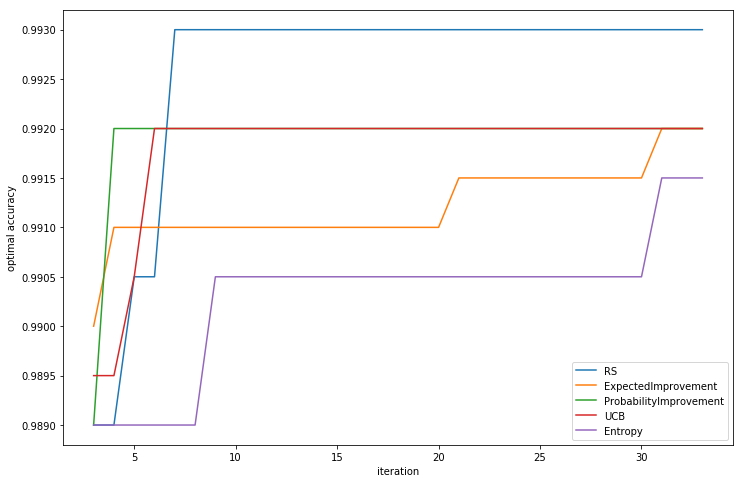

In [5]:
matplotlib.rcParams['figure.figsize'] = [12, 8]
df_acc.plot()
plt.xlabel("iteration")
plt.ylabel("optimal accuracy"); 

some interpreation of results
- first points corresponds to init_evals numbers of initial runs
- unfortunatley, no structured way to store intermediary parameters. what we can see from the print, though is that the models do not exploit the learning rate very aggressively at its lower bound (which would increase accuracy)
- limiations: not taking into account time of fitting